In [1]:
import os
import gc
import sys
import torch
import psutil
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, set_image_backend
import data_utils
import train_utils
import model_utils
import argparse

In [2]:
state_dict_file = '/n/tcga_models/resnet18_WGD_all_10x.pt'
input_size = 2048
hidden_size = 512
output_size = 1

# initialize trained resnet
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(2048, output_size, bias=True)
saved_state = torch.load(state_dict_file, map_location=lambda storage, loc: storage)
resnet.load_state_dict(saved_state)
device = torch.device('cuda',1)
resnet.cuda(device=device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [3]:

for param in resnet.parameters():
    param.requires_grad = False
    
for param in resnet.fc.parameters(): 
    param.requires_grad = True

In [4]:
val_cancers = ['UCEC', 'LIHC_10x', 'KIRC_10x']
root_dir = '/n/mounted-data-drive/'
magnification = '10.0'
criterion=nn.BCEWithLogitsLoss()

In [5]:
pickle_file = '/home/sxchao/MSI_prediction/tcga_project/tcga_wgd_sa_all.pkl'
batch_all, _, _, sa_trains, sa_vals = data_utils.load_COAD_train_val_sa_pickle(pickle_file=pickle_file,
                                                                               return_all_cancers=True, 
                                                                               split_in_two=True)
val_transform = train_utils.transform_validation

In [6]:
val_sets = []


In [7]:
for j in range(len(val_cancers)):
    val_set = data_utils.TCGADataset_tiles(sa_vals[batch_all.index(val_cancers[j])], 
                                           root_dir + val_cancers[j] + '/', 
                                           transform=val_transform, 
                                           magnification=magnification, 
                                           batch_type='tile', 
                                           return_jpg_to_sample=True)
    val_sets.append(val_set)

In [12]:
val_loaders = [torch.utils.data.DataLoader(val_set, 
                                            batch_size=400, 
                                            shuffle=True, 
                                            num_workers=12, 
                                            pin_memory=True,drop_last=True) for val_set in val_sets]

optimizer = torch.optim.Adam(resnet.fc.parameters(), lr = 1e-2) 

In [ ]:
val_loader = val_loaders[0]

losses = np.zeros([10,len(val_loader)])
original_weights = [p.detach().clone() for p in resnet.fc.parameters()]
for step, (batch,labels,jpg_to_sample) in enumerate(val_loader):
    resnet.fc.weight.data = original_weights[0].clone()
    resnet.fc.bias.data = original_weights[1].clone()
    inputs, labels = batch.cuda(device=device), labels.cuda(device=device).view(-1,1).float()
    inputs_a = inputs[:200,:,:,:]
    inputs_b = inputs[200:,:,:,:]
    output_b = resnet(inputs_b)
    loss = criterion(output_b, labels[200:,:]) 
    losses[0,step] = loss.detach().cpu().numpy()
    print((step,loss.detach().cpu().numpy()),end=' ')
    for ix in range(1,10):
        
        output_a = resnet(inputs_a)
        loss = criterion(output_a, labels[:200,:])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        output_b = resnet(inputs_b)
        loss = criterion(output_b, labels[200:,:])
        losses[ix,step] = loss.detach().cpu().numpy()


(0, array(0.7083449, dtype=float32)) (1, array(0.7582043, dtype=float32)) (2, array(0.72835356, dtype=float32)) (3, array(0.72584003, dtype=float32)) (4, array(0.8073308, dtype=float32)) (5, array(0.7464305, dtype=float32)) (6, array(0.678614, dtype=float32)) (7, array(0.7744218, dtype=float32)) (8, array(0.71218526, dtype=float32)) 

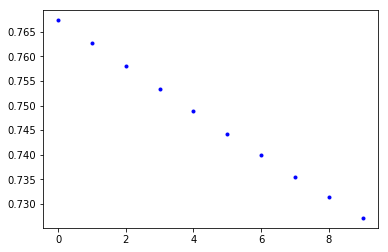

In [10]:
import matplotlib.pyplot as plt
plt.plot(np.mean(losses[:,:],1),'b.')

In [11]:
losses

array([[0.7648645 , 0.75040323, 0.76095134, ..., 0.75641829, 0.70483404,
        0.79912764],
       [0.75952816, 0.74557084, 0.75668335, ..., 0.75102031, 0.70016831,
        0.79375458],
       [0.75426054, 0.74082959, 0.7524339 , ..., 0.74570686, 0.69560736,
        0.78840911],
       ...,
       [0.72899336, 0.71842331, 0.73181123, ..., 0.72059095, 0.67438877,
        0.76246262],
       [0.72416145, 0.7141934 , 0.72785854, ..., 0.71588242, 0.67045987,
        0.7574839 ],
       [0.71940547, 0.71004528, 0.72397369, ..., 0.71128309, 0.66663361,
        0.75258839]])